In [1]:
import ccxt
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import talib

from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
millis = {
    '1m': 60_000,
    '1h': 60_000 * 60,
    '1d': 60_000 * 1440
}

sym = 'XBTUSD'
level = '1m'
limit = 1000
since = None # get latest OHLC data

api = ccxt.bitmex({'enableRateLimit': False})

candles = []

while True:        
    headers = api.last_response_headers or {}
    now = datetime.datetime.utcnow().timestamp()    
    rate_limit = int(headers.get('X-RateLimit-Remaining', 30))
    rate_reset = int(headers.get('X-RateLimit-Reset', now))

    if rate_limit < 10:
        wait = max(5.0, rate_reset - now)
        time.sleep(wait)
    
    response = api.fetchOHLCV(
        sym,
        since=since,
        limit=limit,
        timeframe=level,
    )
    candles = response + candles
    min_time = min(x[0] for x in response)
    since = min_time - limit * millis[level]
    
    if len(candles) >= 20_000:
        break
    

print(api.last_response_headers['X-RateLimit-Remaining'])

columns = 'time open high low close vol'.split()
df = pd.DataFrame(candles, columns=columns)

df = df.drop_duplicates()
df = df.sort_values('time')
df = df.reset_index(drop=True)

def to_datetime(x):
    return datetime.datetime.fromtimestamp(x / 1000)

df['time'] = df['time'].apply(to_datetime)
df

10


,time,open,high,low,close,vol
0,2023-04-09 23:17:00,28185.5,28192.0,28189.5,28190.0,12200.0
1,2023-04-09 23:18:00,28190.0,28190.0,28187.0,28187.0,43300.0
2,2023-04-09 23:19:00,28187.0,28187.0,28185.0,28185.0,16200.0
3,2023-04-09 23:20:00,28185.0,28184.0,28175.5,28176.0,101900.0
4,2023-04-09 23:21:00,28176.0,28176.5,28170.0,28173.0,98500.0
...,...,...,...,...,...,...
19995,2023-04-23 20:32:00,27424.0,27444.5,27426.0,27435.0,117200.0
19996,2023-04-23 20:33:00,27435.0,27433.0,27421.5,27421.5,169900.0
19997,2023-04-23 20:34:00,27421.5,27437.5,27415.5,27437.5,41400.0
19998,2023-04-23 20:35:00,27437.5,27447.0,27440.0,27443.5,120200.0


In [3]:
df['ema'] = talib.EMA(df['close'])
df

,time,open,high,low,close,vol,ema
0,2023-04-09 23:17:00,28185.5,28192.0,28189.5,28190.0,12200.0,NaN
1,2023-04-09 23:18:00,28190.0,28190.0,28187.0,28187.0,43300.0,NaN
2,2023-04-09 23:19:00,28187.0,28187.0,28185.0,28185.0,16200.0,NaN
3,2023-04-09 23:20:00,28185.0,28184.0,28175.5,28176.0,101900.0,NaN
4,2023-04-09 23:21:00,28176.0,28176.5,28170.0,28173.0,98500.0,NaN
...,...,...,...,...,...,...,...
19995,2023-04-23 20:32:00,27424.0,27444.5,27426.0,27435.0,117200.0,27450.307018
19996,2023-04-23 20:33:00,27435.0,27433.0,27421.5,27421.5,169900.0,27448.448500
19997,2023-04-23 20:34:00,27421.5,27437.5,27415.5,27437.5,41400.0,27447.742146
19998,2023-04-23 20:35:00,27437.5,27447.0,27440.0,27443.5,120200.0,27447.468459


<AxesSubplot:xlabel='time'>

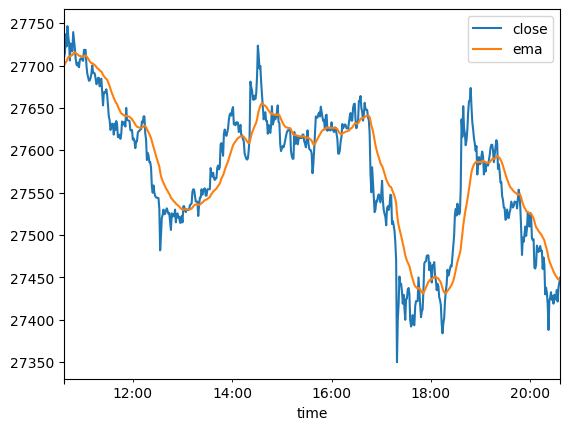

In [4]:
df[-600:].plot(x='time', y=['close', 'ema'])

In [5]:
df['dist'] = np.log(df['close']) - np.log(df['ema'])
df = df.dropna().reset_index(drop=True)
df

,time,open,high,low,close,vol,ema,dist
0,2023-04-09 23:46:00,28345.0,28373.5,28345.5,28369.0,300800.0,28256.766667,0.003964
1,2023-04-09 23:47:00,28369.0,28391.0,28363.0,28378.0,517500.0,28264.588172,0.004004
2,2023-04-09 23:48:00,28378.0,28387.0,28365.0,28387.0,155200.0,28272.485709,0.004042
3,2023-04-09 23:49:00,28387.0,28398.0,28387.0,28396.0,161600.0,28280.454373,0.004077
4,2023-04-09 23:50:00,28396.0,28452.5,28396.0,28410.0,1461000.0,28288.812156,0.004275
...,...,...,...,...,...,...,...,...
19966,2023-04-23 20:32:00,27424.0,27444.5,27426.0,27435.0,117200.0,27450.307018,-0.000558
19967,2023-04-23 20:33:00,27435.0,27433.0,27421.5,27421.5,169900.0,27448.448500,-0.000982
19968,2023-04-23 20:34:00,27421.5,27437.5,27415.5,27437.5,41400.0,27447.742146,-0.000373
19969,2023-04-23 20:35:00,27437.5,27447.0,27440.0,27443.5,120200.0,27447.468459,-0.000145


<AxesSubplot:ylabel='Frequency'>

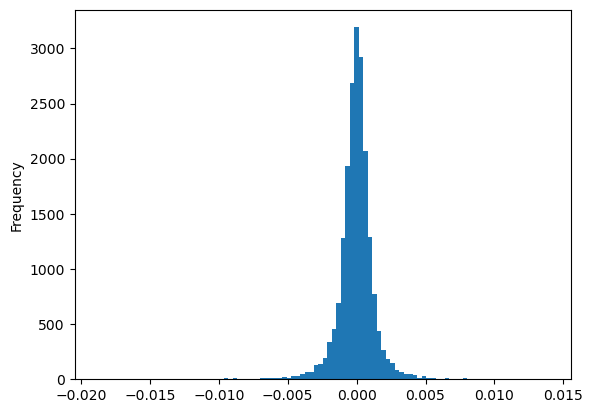

In [6]:
df['dist'].plot(kind='hist', bins=100)

In [7]:
mean = np.mean(df['dist'])
stdev = np.std(df['dist'])

df['z_score'] = (df['dist'] - mean) / stdev
df

,time,open,high,low,close,vol,ema,dist,z_score
0,2023-04-09 23:46:00,28345.0,28373.5,28345.5,28369.0,300800.0,28256.766667,0.003964,2.749164
1,2023-04-09 23:47:00,28369.0,28391.0,28363.0,28378.0,517500.0,28264.588172,0.004004,2.777051
2,2023-04-09 23:48:00,28378.0,28387.0,28365.0,28387.0,155200.0,28272.485709,0.004042,2.803067
3,2023-04-09 23:49:00,28387.0,28398.0,28387.0,28396.0,161600.0,28280.454373,0.004077,2.827333
4,2023-04-09 23:50:00,28396.0,28452.5,28396.0,28410.0,1461000.0,28288.812156,0.004275,2.963491
...,...,...,...,...,...,...,...,...,...
19966,2023-04-23 20:32:00,27424.0,27444.5,27426.0,27435.0,117200.0,27450.307018,-0.000558,-0.369512
19967,2023-04-23 20:33:00,27435.0,27433.0,27421.5,27421.5,169900.0,27448.448500,-0.000982,-0.662278
19968,2023-04-23 20:34:00,27421.5,27437.5,27415.5,27437.5,41400.0,27447.742146,-0.000373,-0.242221
19969,2023-04-23 20:35:00,27437.5,27447.0,27440.0,27443.5,120200.0,27447.468459,-0.000145,-0.084539


In [8]:
np.mean(df['z_score']), np.std(df['z_score'])

(1.565463941387232e-17, 1.0000000000000029)

<AxesSubplot:ylabel='Frequency'>

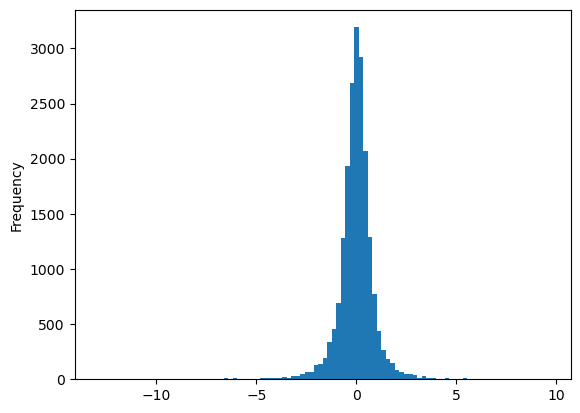

In [9]:
df['z_score'].plot(kind='hist', bins=100)

In [10]:
total = len(df)

rows = []

for z in np.arange(1, 4.1, 0.1):
    count = sum(df['z_score'] > z) + sum(df['z_score'] < -z)
    rows.append({
        'z_score': z,
        'pct': 100 * (count / total)
    })


pd.DataFrame(rows)

,z_score,pct
0,1.0,16.203495
1,1.1,13.754945
2,1.2,11.837164
3,1.3,10.380051
4,1.4,9.018076
5,1.5,7.881428
6,1.6,7.020179
7,1.7,6.203996
8,1.8,5.578088
9,1.9,4.972210


## Trading Idea  

- If z_score > 3 sell 200
- reduce position by 100 when z_score < 2
- close position when z_score < 1  

And vice-versa

- If z_score < -3 buy 200
- reduce position by 100 when z_score > -2
- close position when z_score > -1

<AxesSubplot:xlabel='time'>

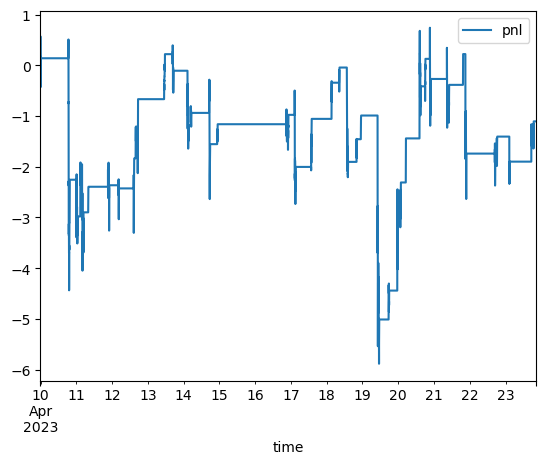

In [11]:
trading_fee = 7.5 / 100 / 100
trading_fee = 0

sig_thres = 3
cls_thres = 0.5


risk = 0

position = []
fees = []


for r in df.itertuples():
    # have no risk
    fee = 0
    
    if risk == 0:
        if r.z_score > sig_thres:
            risk = -200
            fee = 200 * trading_fee
            
        elif r.z_score < -sig_thres:
            risk = 200
            fee = 200 * trading_fee
            
    # have short risk - triggered by z_score > 3
    elif risk == -200:
        if r.z_score < cls_thres:
            risk = 0
            fee = 200 * trading_fee
    
#     elif risk == -100:
#         if r.z_score < 1:
#             risk = 0
#             fee = 100 * taker_fee
    
    # have long risk - triggered by z_score < -3    
    elif risk == 200:
        if r.z_score > -cls_thres:
            risk = 0
            fee = 200 * trading_fee
    
#     elif risk == 100:
#         if r.z_score > -1:
#             risk = 0
#             fee = 100 * taker_fee
            
    
    position.append(risk)
    fees.append(fee)
    

df['risk'] = position
df['fee'] = fees


df['change'] = df['close'].pct_change().shift(-1).fillna(0)

df['pnl'] = (df['change'] * df['risk']) - df['fee'] 
df['pnl'] = df['pnl'].cumsum()


df.plot(x='time', y='pnl')